<a href="https://colab.research.google.com/github/BPALAN-USD/AAI-521-GROUP5/blob/main/AAI521_BhavinPalanAssignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1- Digit generator**

In [1]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [2]:
#a- Reading data
import tensorflow as tf
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data() #Load the mnist dataset from tf.keras
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images =   (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1] by deducting 127.5 and dividing to 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Creating the generative model function
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


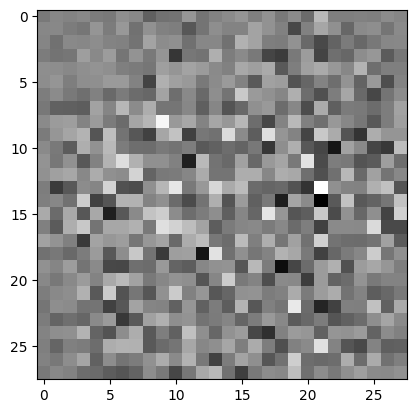

In [4]:
# Use the generator model which is not trained yet to create an image
generator = make_generator_model() # Call the function here

noise = tf.random.normal([1, 100])  #This creates the noise
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
# what is this image?
## It is not clear yet since the image is blur or has lot of noise.

In [5]:
#c- Create discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
# Applying discriminative model on the untrained image which was the output of generative model
discriminator = make_discriminator_model() # Call discriminator function
decision = discriminator(generated_image)
print (decision)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[-0.00185198]], shape=(1, 1), dtype=float32)


In [7]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

<LossFunctionWrapper(<function binary_crossentropy at 0x7df7b39fbe20>, kwargs={'from_logits': True, 'label_smoothing': 0.0, 'axis': -1})>

In [8]:
#d- Compute the loss
# Discriminator loss This method quantifies how well the discriminator is able to distinguish real images from fakes.
# It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output) #Same command as above but for fake_output
    total_loss = real_loss + fake_loss
    return total_loss

In [9]:
#Generator loss The generator's loss quantifies how well it was able to trick the discriminator.
#Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [10]:
#The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) #same adam optimizer here

In [11]:
# e- Model design
# Let's save the model for future references
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [12]:
# Model parametrs
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [13]:
#The training loop begins with generator receiving a random seed as input. That seed is used to produce an image.
#The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
#The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [14]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [15]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

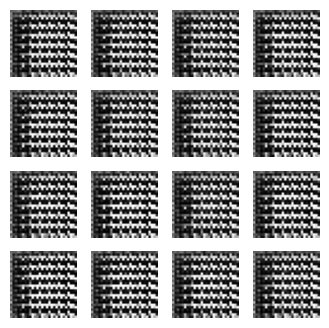

In [16]:
#Call the function in proper waykdkdkddpp[dpddpdpdppdpddpdd[]]mmmmmn
train(train_dataset, EPOCHS)  #Put appropriate values here aoond call the functionkdk

In [17]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

/tmp/ipython-input-2574666166.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


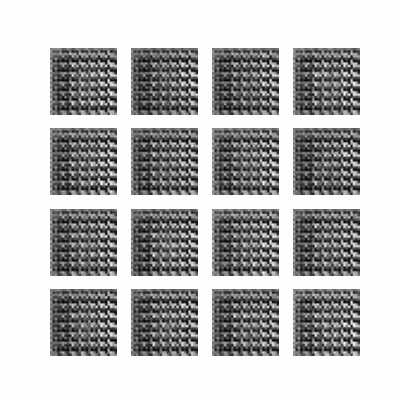

In [21]:
# You can use these commands to save the evpolution as a GIF file
anim_file = 'GAN_digit.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython

display.Image(filename=anim_file)

In [ ]:
# what is your understanding from this GIF file?
## Image Distortation is reduced and more clarity in image can be seen.

**Part 2- Pokemon characters and GAN**

In [22]:
#Install d2l package
!pip install d2l==1.0.0-alpha1.post0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 138.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.8/59.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.1 MB/s eta 0:00:00


In [23]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [24]:
#a- Read the dataset and store it
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

# We store the directory in this variable
data_dir = d2l.download_extract('pokemon')
batch_size = 256
# Use preprocessing from Keras to read images from directory using given batch size and map them to 64x64 images
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [26]:
#Normalize the data between [-1,1]
# We normalize the data with  0.5  mean and  0.5  standard deviation to match the value range
# Write a function to normalize the images by dividing them to 255 and use gaussian normalization with mean of 0.5 and standard deviation of 0.5.
def transform_func(X):
  X = tf.cast(X, tf.float32) / 255.0       # Scale to [0,1]
  X = (X - 0.5) / 0.5                       # Normalize to [-1,1]
  return X
    # Write the function here in which it normalied the X in the way explained above.


data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

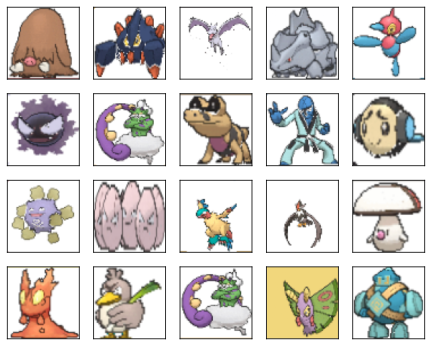

In [27]:
#b- Visualize first 20 images
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

## The Generator

The generator needs to map the noise variable to a RGB image with width and height to be $64\times 64$ .

In [28]:
#c- Creating the generator
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [ ]:
# Explain your understanding of the G_block here.
## A G_block is a small building piece used in the generator of a GAN. Its job is to take a small, low-resolution feature map and make it bigger while adding detail, so eventually we can get a full image.

In [29]:
x = tf.zeros((2, 16, 16, 3))  # Input based on the instruction
#Call the G_block package and use 20 as the number of layers (input of the class)
g_blk = G_block(20)
# Show the dimension of the output
g_blk(x).shape

TensorShape([2, 32, 32, 20])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [30]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

In [31]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

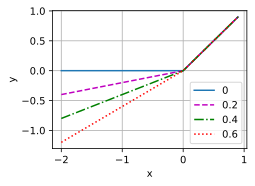

In [32]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block

In [33]:
# d- Block of Discriminator
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [ ]:
# Explain your understanding of D_block here.
## It takes the image and try to extract the feature and meaningfull information from it.

In [34]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
d_blk = D_block(20)
# Show the dimension of the output
d_blk(x).shape


TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.


In [35]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

In [36]:
#It uses a convolution layer with output channel  1  as the last layer to obtain a single prediction value.
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training




In [40]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_hp = {"learning_rate": lr, "beta_1": 0.5, "beta_2": 0.999}
    optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
    optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3) # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1,
                                 shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        # Show generated examples
        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)],
                                    axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')

In [ ]:
# Explain your understanding from this model here?
## This code trains a GAN by repeatedly updating the discriminator to tell real vs fake images apart and the generator to produce more realistic images, while showing the evolving losses and generated images each epoch.

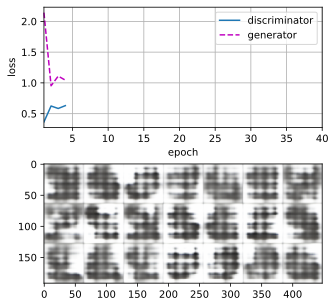

In [ ]:
#We train the model with a small number of epochs just for demonstration. For better performance, the variable num_epochs can be set to a larger number.
latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D=net_D,
      net_G=net_G,
      data_iter=data_iter,
      num_epochs=num_epochs,
      lr=lr,
      latent_dim=latent_dim)

In [ ]:
# what is your understanding from this learning curve?
